# 0.0. Importações

In [2]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML

## 0.2. Carregar os Dados

In [3]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory= False )
df_store_raw = pd.read_csv( 'store.csv', low_memory= False )


# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

# 1.0. Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [5]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

new_cols = list( map( snakecase, old_cols ))

df1.columns = new_cols

## 1.2. Dimensões dos Dados

In [6]:
print( 'Numero de Linhas:  {}'.format( df1.shape[0] ) )
print( 'Numero de Colunas: {}'.format( df1.shape[1] ) )

Numero de Linhas:  1017209
Numero de Colunas: 18


## 1.3. Tipos de Dados

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 20000.0 if math.isnan( x ) else x )

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )
                      
# promo2_since_week            
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

# promo2_since_year            
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

## 1.6. Mundanca de Tipos

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Estatítisca Descritiva

In [11]:
num_atributos = df1.select_dtypes( include = ['int64', 'float64'] )
cat_atributos = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Atributos Numéricos

In [12]:
# tendencia central - mean, median
tc1 = pd.DataFrame( num_atributos.apply( np.mean ) ).T
tc2 = pd.DataFrame( num_atributos.apply( np.median ) ).T

# dispersao - max, min, std, range, skew, kurtosis
d1 = pd.DataFrame( num_atributos.apply( max ) ).T
d2 = pd.DataFrame( num_atributos.apply( min ) ).T
d3 = pd.DataFrame( num_atributos.apply( np.std ) ).T
d4 = pd.DataFrame( num_atributos.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributos.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributos.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d1, d4, tc1, tc2, d3, d5, d6] ).T.reset_index()
m.columns = ['Atributos', 'Min', 'Max', 'Range', 'Media', 'Mediana', 'STD', 'Skew', 'Kurtosis']

m

,Atributos,Min,Max,Range,Media,Mediana,STD,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5467.928135,2330.0,7740.896804,2.894723,12.724442
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Atributos Categoricos

In [34]:
cat_atributos.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

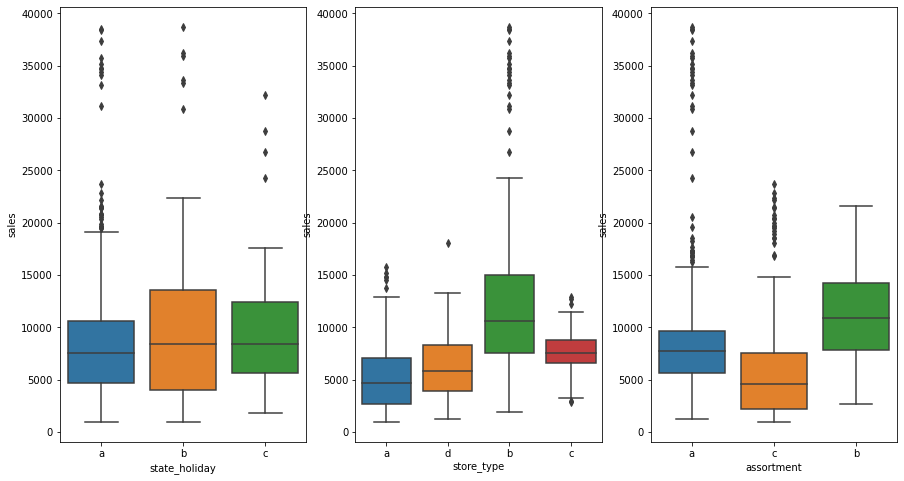

In [49]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.figure( figsize=( 15,8 ) )

plt.subplot( 1, 3, 1 )
sns.boxplot( x= 'state_holiday', y='sales' , data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x= 'store_type', y='sales', data= aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x= 'assortment', y = 'sales', data= aux1 );

## 1.8.